In [1]:
import os

os.environ['SPARK_VERSION'] = '3.3'

from pyspark.sql import SparkSession, Row
import pydeequ

# Now, you can proceed with your SparkSession setup and the rest of your code
spark = (SparkSession
    .builder
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .config("spark.scheduler.maxRegisteredResourcesWaitingTime", "5000")
    .config("spark.scheduler.minRegisteredResourcesRatio", "1.0")
    .config("spark.sql.debug.maxToStringFields", "100")
    .appName("test") \
    .getOrCreate())

In [2]:
df = spark.read.csv("kc_house_data.csv", header=True, inferSchema=True)

In [3]:
import os

# Replace this with the path to your file
file_path = 'kc_house_data.csv'

# Getting the size of the file
file_size = os.path.getsize(file_path)

print(f"The size of the file is: {file_size} bytes")

The size of the file is: 2515206 bytes


In [4]:
affichage = []
for i in range(1,6):
    affichage.append(round(file_size * 0.2 * i))
print(affichage)

[503041, 1006082, 1509124, 2012165, 2515206]


In [5]:
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *
import time
import matplotlib.pyplot as plt
from pydeequ.analyzers import *

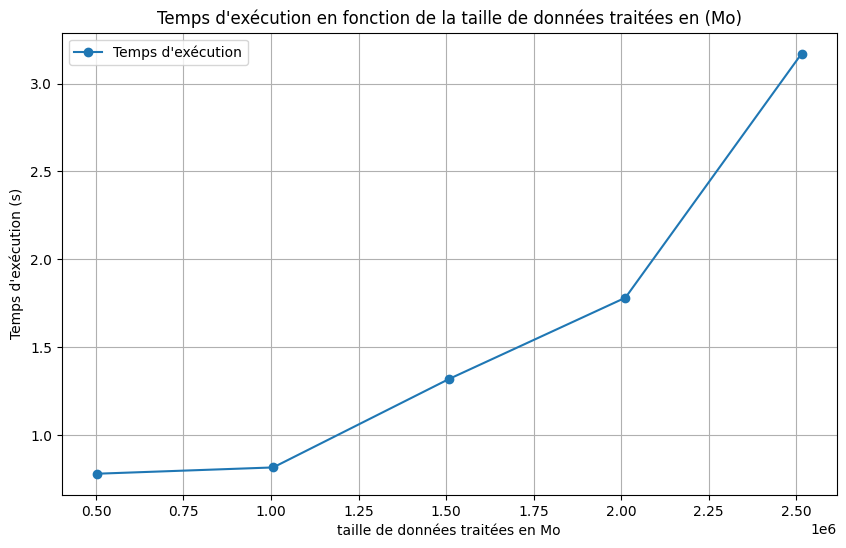

In [6]:
# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch = []
completeness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Completeness Check")
    completeness_check = check.isComplete("id")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(check.isComplete("id")
                  .isComplete("price")
                  .isComplete("zipcode")
                  .isComplete("grade")) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'CompletenessConstraint' in result['constraint']:
                completeness_status = result['constraint_status']  # 'Success' or 'Failure'
                completeness_message = result['constraint_message']
                if completeness_message != "" :
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    completeness_value = float(completeness_message.split('Value: ')[1].split(' ')[0])
                
                    completeness_results.append(completeness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

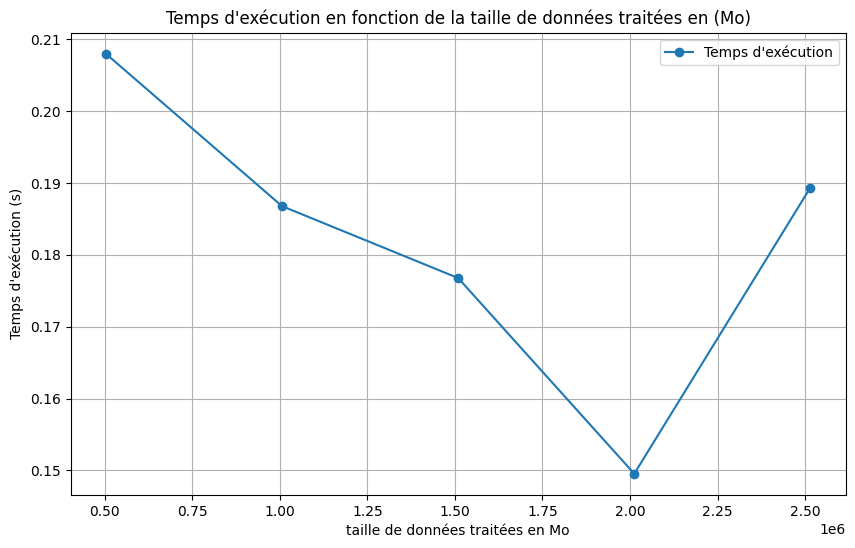

In [7]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental = []
completeness_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Completeness Check")
    completeness_check = check.isComplete("id")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    analysisResult = AnalysisRunner(spark) \
                    .onData(df) \
                    .addAnalyzer(Size()) \
                    .run()
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(check.isComplete("id")
                  .isComplete("price")
                  .isComplete("zipcode")
                  .isComplete("grade")) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'CompletenessConstraint' in result['constraint']:
                completeness_status = result['constraint_status']  # 'Success' or 'Failure'
                completeness_message = result['constraint_message']

                if completeness_message != "" :
                    # Extract the completeness value from the message
                    # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    completeness_value = float(completeness_message.split('Value: ')[1].split(' ')[0])
                    completeness_results.append(completeness_value)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()


# completeness fig 5

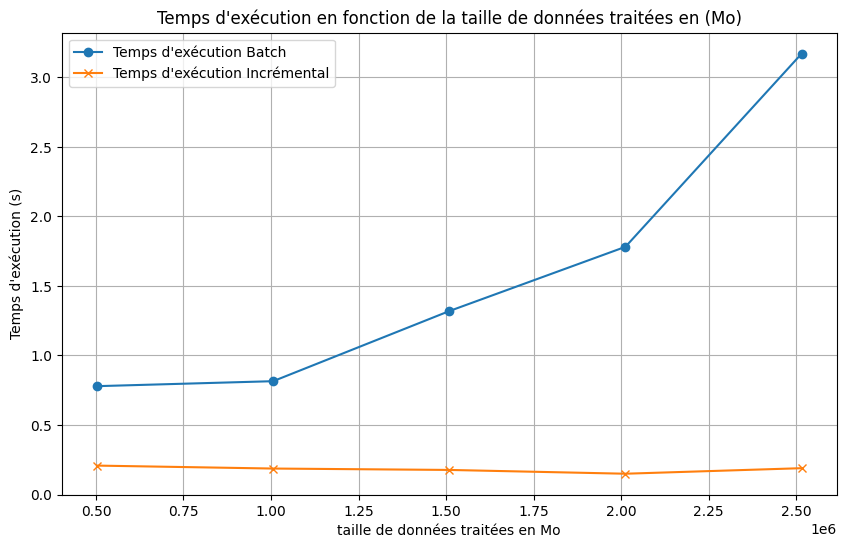

In [8]:
# Visualisation des deux modes sur un seul graphique
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch, marker='o', label='Temps d\'exécution Batch')
plt.plot(affichage, times_incremental, marker='x', label='Temps d\'exécution Incrémental')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

## Uniqueness fig 6

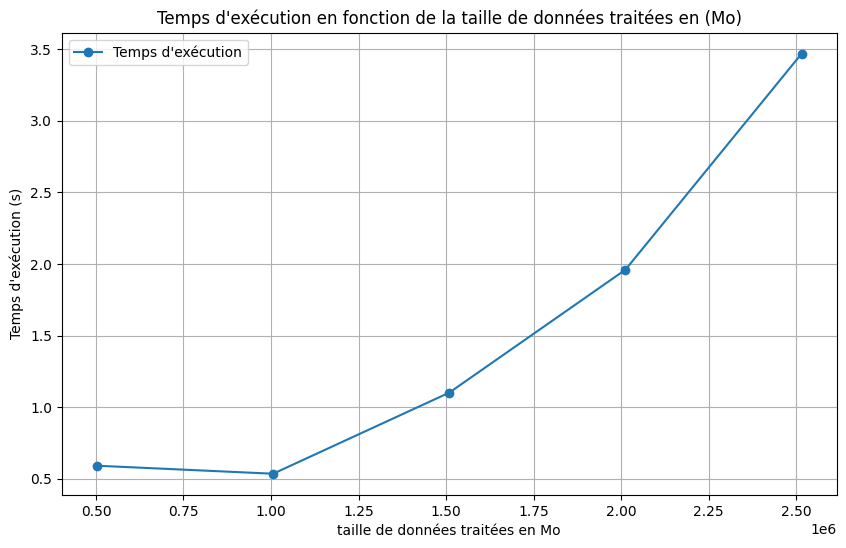

In [9]:
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *
import time
from pydeequ.analyzers import *
import matplotlib.pyplot as plt

# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch = []
Uniqueness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("bathrooms")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    analysisResult = AnalysisRunner(spark) \
            .onData(accumulated_data) \
            .addAnalyzer(Entropy("bathrooms"))

    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                
                Uniqueness_results.append(Uniqueness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

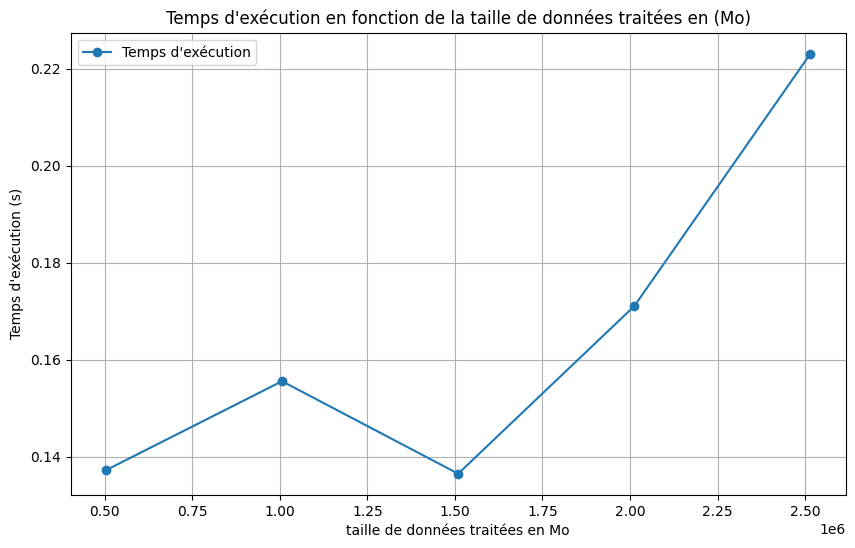

In [10]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental = []
Uniqueness_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("bathrooms")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()

    analysisResult = AnalysisRunner(spark) \
            .onData(current_segment) \
            .addAnalyzer(Entropy("bathrooms"))
    
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                
                Uniqueness_results.append(Uniqueness_value)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

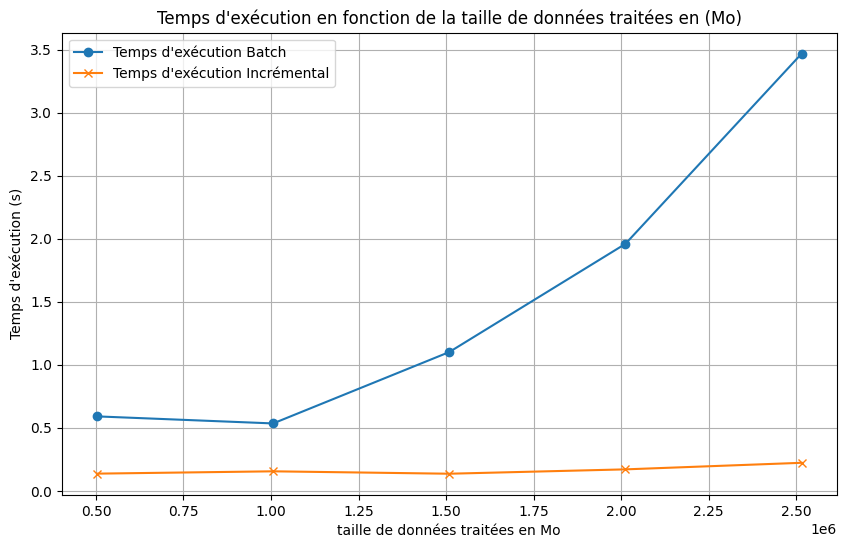

In [11]:
# Visualisation des deux modes sur un seul graphique
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch, marker='o', label='Temps d\'exécution Batch')
plt.plot(affichage, times_incremental, marker='x', label='Temps d\'exécution Incrémental')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

# figure 7

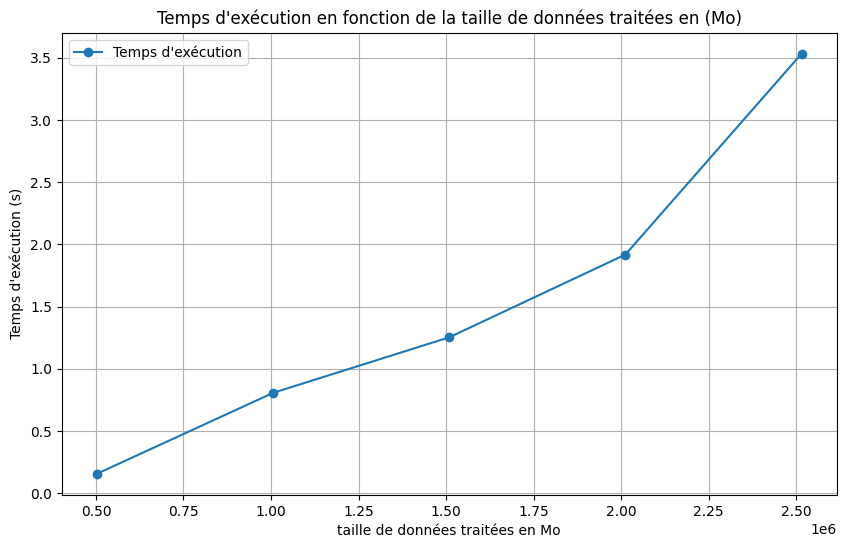

In [12]:
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *
import time
from pydeequ.analyzers import *
import matplotlib.pyplot as plt

# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch = []
Uniqueness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("price")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    analysisResult = AnalysisRunner(spark) \
            .onData(accumulated_data) \
            .addAnalyzer(Entropy("price"))

    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                
                Uniqueness_results.append(Uniqueness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

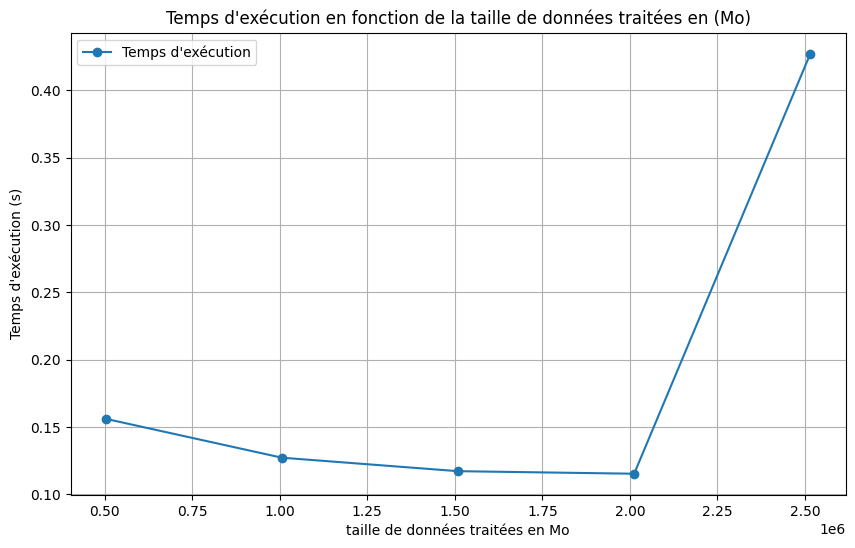

In [13]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental = []
Uniqueness_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("price")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()

    analysisResult = AnalysisRunner(spark) \
            .onData(current_segment) \
            .addAnalyzer(Entropy("price"))
    
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                
                Uniqueness_results.append(Uniqueness_value)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

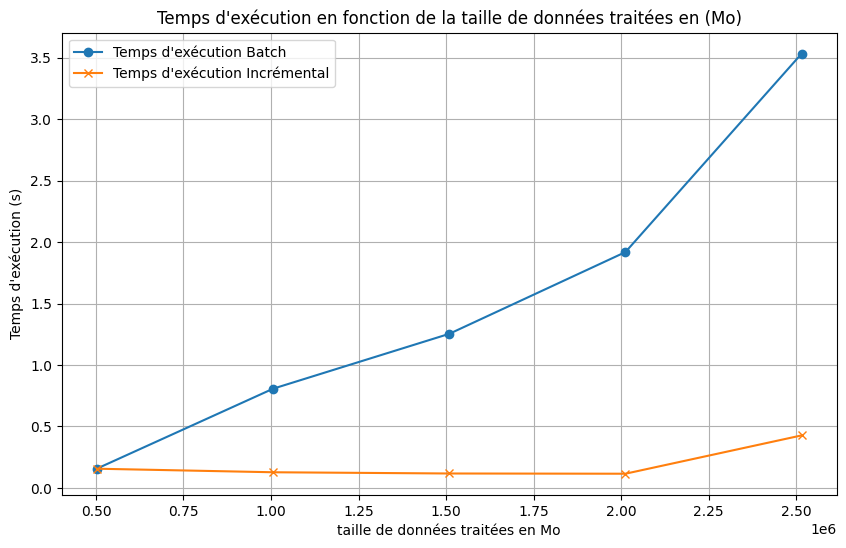

In [14]:
# Visualisation des deux modes sur un seul graphique
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch, marker='o', label='Temps d\'exécution Batch')
plt.plot(affichage, times_incremental, marker='x', label='Temps d\'exécution Incrémental')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

# figure 8

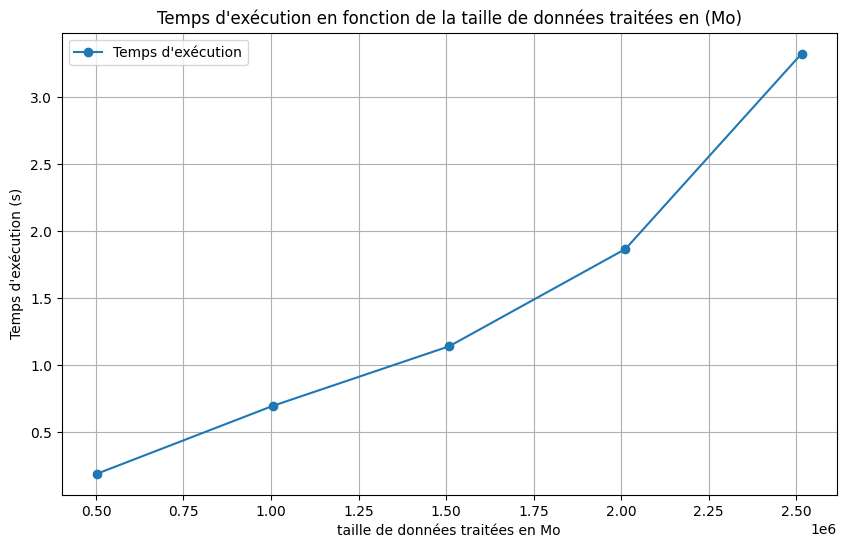

In [15]:
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *
import time
from pydeequ.analyzers import *
import matplotlib.pyplot as plt

# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch = []
Uniqueness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("id")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()
    
    analysisResult = AnalysisRunner(spark) \
            .onData(accumulated_data) \
            .addAnalyzer(Entropy("id"))

    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                
                Uniqueness_results.append(Uniqueness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

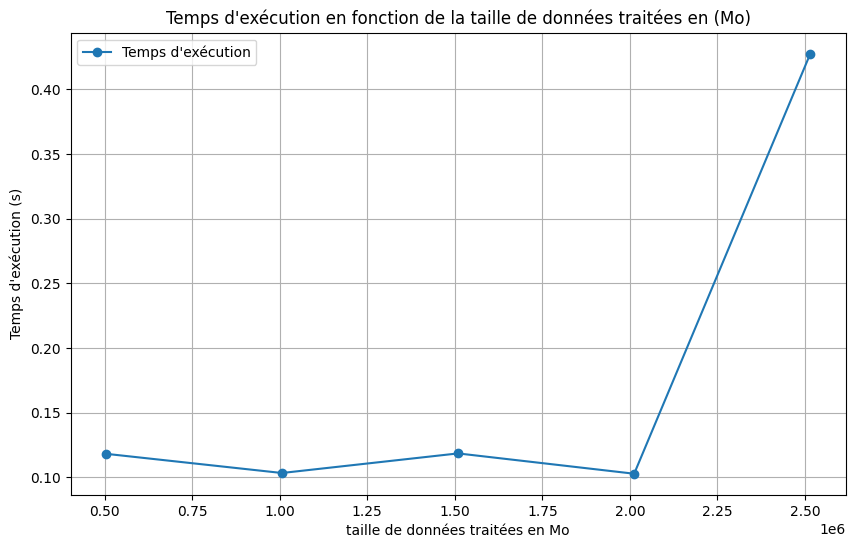

In [16]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *

# Supposons que la SparkSession est déjà créée et configurée
# ...

# Charger les données dans un DataFrame Spark et les cacher
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_incremental = []
Uniqueness_results = []

# Traiter les données par segments de 20% sans retraitement
for i in range(1, 6):
    # Calculer la fin du segment actuel
    segment_end = int(total_count * 0.2 * i)
    
    # Sélectionner uniquement le segment actuel de données
    current_segment = data.limit(segment_end).subtract(data.limit(segment_end - int(total_count * 0.2))).cache()
    
    # Forcer l'évaluation du segment actuel
    current_segment.count() 

    # Définir la vérification de la complétude pour le segment actuel
    check = Check(spark, CheckLevel.Warning, "Data Uniqueness Check")
    Uniqueness_check = check.isUnique("id")  # Remplacer par le nom réel de votre colonne

    # Démarrer le chronomètre
    start_time = time.time()

    analysisResult = AnalysisRunner(spark) \
            .onData(current_segment) \
            .addAnalyzer(Entropy("id"))
    
    # Exécuter la vérification de la complétude pour le segment actuel
    verification_result = VerificationSuite(spark) \
        .onData(current_segment) \
        .addCheck(Uniqueness_check) \
        .run()
    end_time = time.time()
    
    # Calculer et enregistrer le temps écoulé
    elapsed_time = end_time - start_time
    times_incremental.append(elapsed_time)

    # Libérer la mémoire
    current_segment.unpersist()

    # Détails sur les résultats de complétude pour le segment actuel
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'UniquenessConstraint' in result['constraint']:
                Uniqueness_status = result['constraint_status']  # 'Success' or 'Failure'
                Uniqueness_message = result['constraint_message']
                
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                Uniqueness_value = float(Uniqueness_message.split('Value: ')[1].split(' ')[0])
                
                Uniqueness_results.append(Uniqueness_value)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_incremental, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

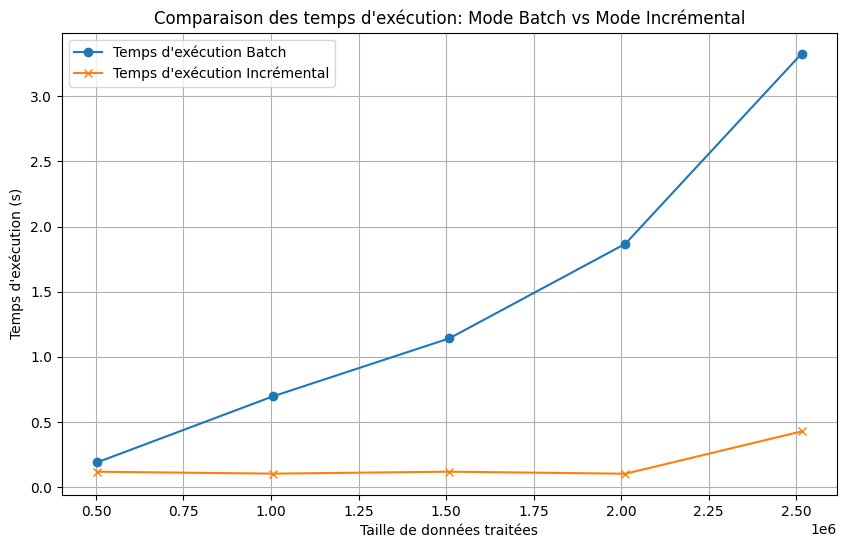

In [17]:
# Visualisation des deux modes sur un seul graphique
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch, marker='o', label='Temps d\'exécution Batch')
plt.plot(affichage, times_incremental, marker='x', label='Temps d\'exécution Incrémental')
plt.xlabel('Taille de données traitées')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Comparaison des temps d\'exécution: Mode Batch vs Mode Incrémental')
plt.legend()
plt.grid(True)
plt.show()